# Cloud Diffusion: Training
Here we put the theory developed in the previous two notebooks to practice. Our goal is to construct a new type of diffusion model, generically called Cloud Diffusion, that employs scale invariant noise whose scaling parameters are fine-tuned to match the low-order statistics of the dataset. This noise is used to progressively corrupt the images on a time schedule, and the model is trained to separate out the signal from the noise. Images are generated by seeding the model with pure cloud noise, then progressively removing the inferred noise through the reverse time schedule.

Since the model works the same way in principle to ordinary diffusion models, the architecture will be similar. In particular, our models use variations on the general UNet architecture. 

This notebook is the third in a series:
1. [Cloud Diffusion Part 1: Scale Invariance](./CD_Scale_Invariance.ipynb)
2. [Cloud Diffusion Part 2: Overview](./CD_Overview.ipynb)
3. [Cloud Diffusion Part 3: Training (this notebook)](./CD_Training.ipynb)
4. [Cloud Diffusion Part 4: Inference](./CD_Inference.ipynb)

## UNet Architecture
Diffusion models function by taking an image corrupted by noise and training a model to separate the signal from the noise. Ordinary diffusion models use white noise where each pixel is statistically uncorrelated with neighboring pixels. This property simplifies training somewhat -- when the model encounters statistical correlations between neigboring pixels it can safely assume the correlations are from the signal and not from the noise.

A UNet architecture is a convolutional neural network architecture that is optimized for identifiying correlations between neighboring pixels. It does this through a series of down-blocks that reduce the image resolution in favor of convolutional layers, effectively  increasing the size of the convolutional kernel relative to the image size. Thus, each depth layer in the UNet samples correlations between neighboring pixels at longer distance scales. The results of all layers are combined through a series of up-blocks where results from each depth layer are recombined with the output of deeper layers. If the UNet is deep enough, it captures correlations at all length scales, and uses this to separate the signal from the noise.

Cloud Diffusion works on a similar premise. However, since cloud noise is fine-tuned to have similar low-order statistical features as the image set, it is potentially more difficult to train. Since cloud noise itself has long distance correlations, when the model encounters statistical correlations between neighboring pixels it cannot safely assume that the correlations are signal as opposed to noise. Nevertheless, the UNet architectures strength in identifying distance correlations makes it well suited for Cloud Diffusion. However, as problem is more complex, we might expect that Cloud Diffusion may require deeper and wider UNets than their white-noise counterparts. 

The real advantage of Cloud Diffusion Models comes in the generative phase. As we have argued, we should expect that since cloud noise is (in a quantifiable sense) closer to the image set, that the iterative inference procedure will have a shorter distance to travel, and thus will be faster. Moreover, as opposed to white-noise diffusion models, which build images progressively from coarse features to fine details, Cloud Diffusion builds images more holistically addressing all wavelengths simultaneously. This can be advantageous, especially when the image generation procedure is guided by text or other inference prompts.

## The Setup
Below we load all the relevant packages and data for the Cloud Diffusion Model...

In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision.utils
import importlib
import data
import helpers
import unet
import cloud_diffusion as cd
import copy

In [40]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(unet)
importlib.reload(cd)

<module 'cloud_diffusion' from '/Users/ac.randono/Python Projects/AI Experiments/Scale Invariance/cloud_diffusion.py'>

### Datasets and Dataloaders
The dataset is pulled from the STL10 unlabeled dataset consisting of 10,000 images in natural settings. Following the procedure in [Scale Invariance](./CD_Scale_Invariance.ipynb), we first filter the dataset and dataloaders to remove images that contain light or dark bars on the image edges. The images are minimally processed applying only a grayscale transformation for a single color channel.

In [2]:
batch_size = 64
color_channels = 1
N = 96
num_workers = 4

In [3]:
device = helpers.getDevice()
print(device)

mps


In [4]:
clean_dataset, dirty_dataset = data.get_datasets(batch_size=batch_size, grayscale=True)
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

37157/100000 images (37.157%), moved to dirty dataset.
Clean list clipped to 62784 images so it is divisible by batch_size=64.


### Calculating the mean and standard deviation
We calculate the pixelwise mean and std of the clean image set, which we will use to normalize the images on a pixel-by-pixel basis. 
As discussed in [Scale Invariance](./Scale_Invariance.ipynb) the probability density function of the Fourier transformed image set can be reasonably approximated by a complex multivariate normal distribution with variance tensors
$$
{\Sigma^{ij}}_{kl} = \frac{A^2}{r^{2\Delta}} \delta^i_k\delta^j_l \quad \quad {C^{ij}}_{kl}=0 
$$
where the constant $\Delta$ is measured to be
$$
\begin{eqnarray}
\Delta &=& 1.4999373536194076\,.
\end{eqnarray}
$$
We determine $A$ by requiring that the noise in position space is normalized to have standard deviation equal to $1$.

In [5]:
Delta = 1.4999373536194076
A = 0.10369472586624558

# Uncomment below if we need to recalculate A
# noise_generator = helpers.NoiseGenerator(N=N)
# Delta = 1.4999373536194076
# A = noise_generator_96.get_normalizing_A(Delta=Delta, n_batches=10000, device="mps")

The position space mean and standard deviation are used to normalize the images to have mean $0$ and standard deviation $1$. Note that we will employ a pixel-by-pixel normalization – the mean and std of each pixel of the image set is calculated and used to normalize that pixel. This is justified because the mean and std are nearly homogenous in position space as seen in [Scale Invariance](./Scale_Invariance.ipynb). 

In [6]:
mu, std = helpers.get_mu_and_std(dataloader, device=device)

Calculated mean and standard deviation in 148.85867500305176 seconds.


In [7]:
noise_generator = helpers.NoiseGenerator(N=N, device=device)

### The Model Variables
Here we define a ModelVariables class to serve as a container for our adjustable variables. We'll define generic parameters here that we will adjust for each model.

In [8]:
mv = cd.ModelVariables()

In [9]:
# Model Type ("white", "cloud", or "whitening")
mv.model_type = "cloud"

# DataLoader
mv.dataloader = dataloader

# image norm, std, A, Delta
mv.mu=mu
mv.std=std
mv.A=A
mv.Delta=Delta
mv.eigs=None #(L,V) for color models

# batch size, color channels, image size (NxN)
mv.batch_size=batch_size
mv.color_channels=color_channels
mv.N=N

# Scale factor for channels in UNet. Channels start at scale_factor and double at each downblock. 
# A scale factor of 32 has ~2M parameters. A scale factor of 42 has ~3.36M parameters. 
mv.scale_factor=42

# Device ("cpu", "cuda", or "mps")
mv.device=device

# Number of epochs
mv.n_epochs=5

# Diffusion time steps
mv.T=1000

# data type
mv.dtype=torch.float

# Color map for visualization
mv.cmap = "gray"

# normalization mode for fft (default should be "ortho" for symmetric normalization)
mv.fft_norm="ortho"

# Activation function
# mv.activation=torch.nn.ReLU()
mv.activation=torch.nn.LeakyReLU()
# mv.activation = torch.nn.SiLU()

# Work in Real Fourier Space? If so, everything is converted using rfft and output is in real Fourier Space.
mv.real_fourier_space = False

# Loss Function (use L2 distance for white-noise models and Mahalanobis Loss for Cloud Models)
#mv.loss_function = cd.KL_Loss_Color(Delta=mv.Delta, dist=noise_generator_96.dist, eigs=mv.eigs, device=mv.device, epsilon=0.01)
mv.loss_function = cd.Mahalanobis_Loss(Delta=mv.Delta, 
                                       dist=noise_generator.dist,
                                       real_fourier_space=mv.real_fourier_space,
                                       device=mv.device, 
                                       epsilon=0.005)
#mv.loss_function = cd.L2Loss(device=mv.device)

# Diffusion schedule (cosine diffusion schedule is standard)
mv.diffusion_schedule=cd.offset_cosine_diffusion_schedule

# AdamW optimizer parameters
mv.max_learning_rate=.001
mv.min_learning_rate=.0001
mv.betas=(0.9, 0.999)
mv.weight_decay=0.01

# Cap number of training batches (set to None for no cap)
mv.n_train_batches = None

## White Noise Diffusion
We start with a classic white-noise diffusion model. This will set a baseline of training performance for our UNet architecture that we can use for comparison purposes. For the white-noise model we use standard white noise with diagonal variance ${\Sigma^{ij}}_{kl}\sim \delta^i_k\delta^j_l$ (in both real and Fourier space). The loss function is the ordinay L2 squared Euclidean distance between the noise and the predicted noise. We use an offset cosine diffusion schedule and embed the time-steps using sinusoidal embedding.

In [41]:
mv_white = copy.copy(mv)
mv_white.model_type = "white"
mv_white.loss_function = cd.L2Loss(device=mv_white.device)

In [26]:
white_model = cd.CloudDiffusionModel(mv=mv_white)

RealCloudDiffusionModel Parameters = 3359539


In [28]:
torch.mps.empty_cache()

Epoch: 5/5 | Batch: 980/981 | Loss: 742.8176879882812
Total Time (minutes): 127.26803607145945 | Time per batch: 1.4871249198913574


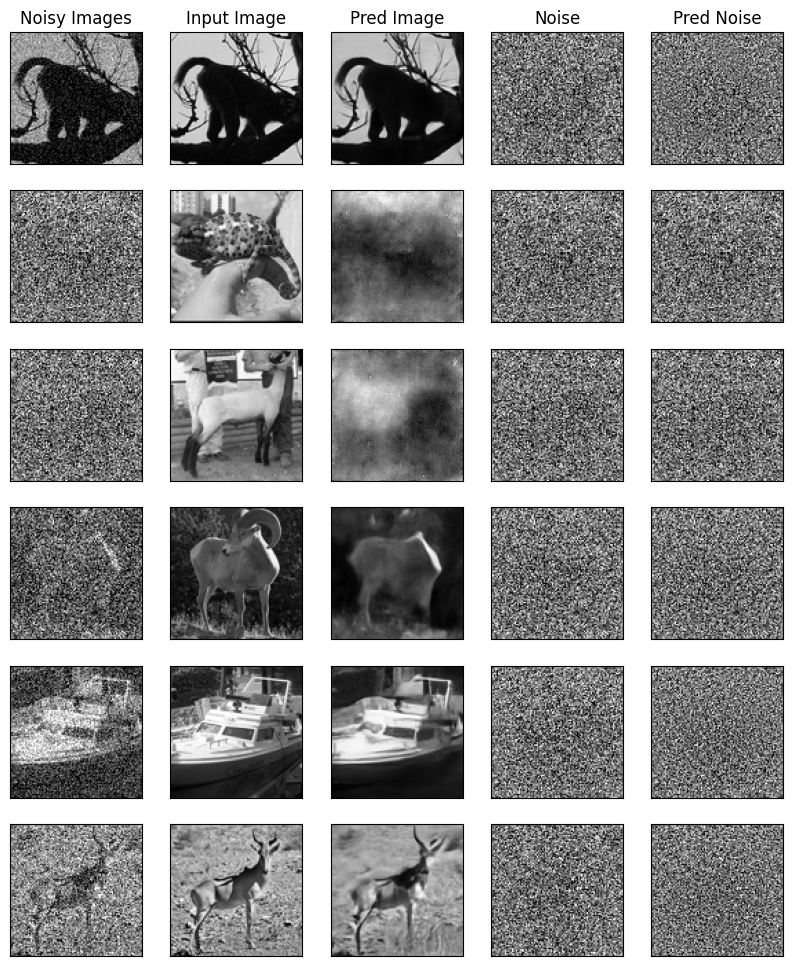

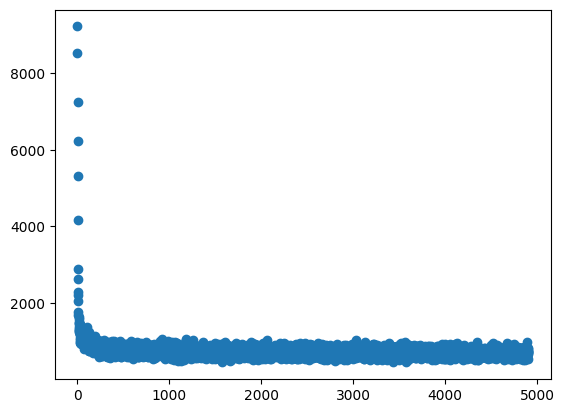

In [29]:
losses = white_model.train_it()

In [ ]:
# Saving the model
data.save_checkpoint(white_model, "white_model_1", mv_white)

## Cloud Noise Model
Let's now turn to the cloud noise model. We will start by using the same UNet architecture as the white noise model and work in real space (as opposed to Fourier space). The images are corrupted with scale invariant cloud noise and the model is trained to separate the signal from the noise. Ultimately the model is evaluated on its ability to predict the noise, and the loss function is the Mahalanobis distance between the predicted noise and the actual noise.

Most of the major variables will carry over from the white noise model with the primary exception being the loss function...

In [10]:
# Adjust the model variables
mv_cloud = copy.copy(mv)
mv_cloud.model_type = "cloud"
mv_cloud.loss_function = cd.Mahalanobis_Loss(Delta=mv_cloud.Delta, 
                                       dist=noise_generator.dist,
                                       real_fourier_space=mv_cloud.real_fourier_space,
                                       device=mv_cloud.device, 
                                       epsilon=0.001)

In [11]:
cloud_model = cd.CloudDiffusionModel(mv=mv_cloud)

Model Parameters = 3359539


In [12]:
torch.mps.empty_cache()

Epoch: 5/5 | Batch: 980/981 | Loss: 1.1231269836425781
Total Time (minutes): 119.0965671658516 | Time per batch: 1.4947712421417236


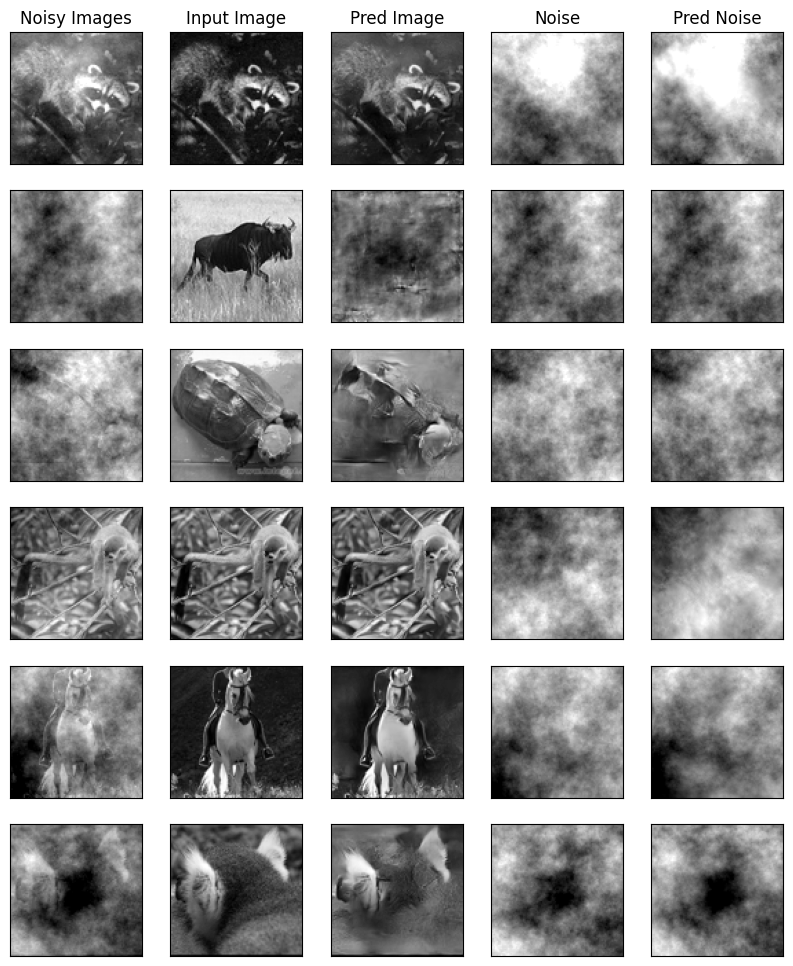

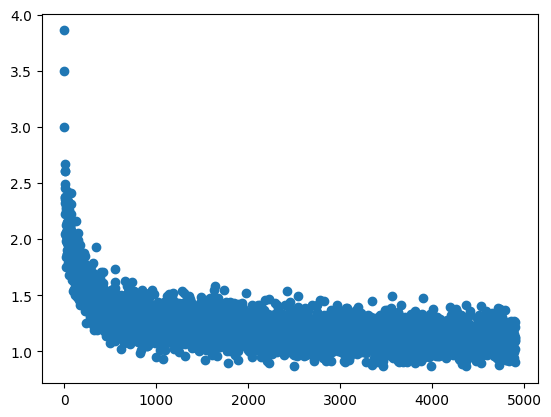

In [13]:
losses = cloud_model.train_it()

In [14]:
# Saving the model
data.save_checkpoint(cloud_model, "cloud_model_1")

Saved model to checkpoints/cloud_model_1.tar
